![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# ViT Bonus Notebook

This notebook is a bonus notebook that demonstrates how to use the Vision Transformer (ViT) model for image classification. The dataset used is the [Bees vs Wasps dataset](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp) from Kaggle. The dataset contains images of fruits and their bounding boxes. The goal, as in notebooks 1 and 1.2 is to classify the images into one of the four classes.

As before, the dataset was found on Kaggle. [Check out the dataset information](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp)

<img src="images/vit_cover_image.png" 
        alt="Image of an insect broken into transformer tokens" 
        width="1000" 
        height="600" 
        style="display: block; margin: 0 auto" />

In this notebook we will code our own ViT model from scratch using PyTorch. We will also use the `torchvision` library to load the dataset and preprocess the images. Vision Transformers (ViTs) are a newer class of models that have shown great promise in image classification tasks. They are based on the Transformer architecture, which was originally designed for natural language processing tasks. ViTs have shown to be competitive with CNNs on image classification tasks, and have the added advantage of being able to capture long-range dependencies in the data. A downside of ViTs is that they can be computationally expensive to train, and require larger amounts of data to perform well versus CNNs.



## 1.  Import the libraries we will use

In [1]:
# Importing supporting libraries
import os
import sys
import json
import random
import pathlib
import requests
import zipfile
import time
import tarfile

import cv2


# Importing the necessary libraries for the dataset
import numpy as np # NumPy
from PIL import Image # Python Imaging Library
import pandas as pd # Pandas
from sklearn.model_selection import train_test_split # Train-Test Split
from sklearn.preprocessing import StandardScaler # Standard Scaler
from sklearn.datasets import fetch_openml # Fetch OpenML
from sklearn.metrics import accuracy_score # Accuracy Score
from sklearn.metrics import confusion_matrix

# Importing the necessary libraries for the visualization
import matplotlib.pyplot as plt # Matplotlib
%matplotlib inline



# Importing the necessary libraries for ViT
import torch # PyTorch
import torch.nn as nn # Neural Network Module
import torch.nn.functional as F # Functional Module that contains activation functions
import torchvision # TorchVision
from tqdm import tqdm # TQDM for displaying progress bar
from einops import rearrange # Rearrange function that rearranges the dimensions of the input tensor
from einops.layers.torch import Rearrange # Rearrange Layer that rearranges the dimensions of the input tensor
from torch import einsum # Einsum function that performs a contraction on the input tensor, similar to a Convolutional Layer
from torchvision import transforms # Transforms that are used for data augmentation
# from torchsummary import summary # Summary function that displays the architecture of the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')


Training on cuda


## 2. Getting the data

As we did in Notebook 1, we will have to download the dataset. This time the file is stored as a zip file, so we will need to extract it. 

In [2]:
def download_file(url="https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz?dl=1", filename="bee_vs_wasp.tar.gz"):

    # Download the file using requests
    response = requests.get(url, stream=True)

    # Create a file object and write the response content in chunks
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Wait for the file to finish downloading
    while not os.path.exists(filename):
        time.sleep(1)

    # Print a success message
    print(f"Downloaded {filename} successfully.")

def extract_file(filename, data_folder):
    # Check if the file is a tar file
    if tarfile.is_tarfile(filename):
        # Open the tar file
        tar = tarfile.open(filename, "r:gz")
        # Extract all the files to the data folder
        tar.extractall(data_folder)
        # Close the tar file
        tar.close()
        # Print a success message
        print(f"Extracted {filename} to {data_folder} successfully.")
    else:
        # Print an error message
        print(f"{filename} is not a valid tar file.")
    
def manage_data(folder_name='bee_vs_wasp'):
    '''Try to find the data for the exercise and return the path'''
    
    # Check common paths of where the data might be on different systems
    likely_paths= [os.path.normpath(f'/blue/practicum-ai/share/data/{folder_name}'),
                   os.path.normpath(f'/project/scinet_workshop2/data/{folder_name}'),
                   os.path.join('data', folder_name),
                   os.path.normpath(folder_name)]
    
    for path in likely_paths:
        if os.path.exists(path):
            print(f'Found data at {path}.')
            return path

    answer = input(f'Could not find data in the common locations. Do you know the path? (yes/no): ')

    if answer.lower() == 'yes':
        path = os.path.join(os.path.normpath(input('Please enter the path to the data folder: ')),folder_name)
        if os.path.exists(path):
            print(f'Thanks! Found your data at {path}.')
            return path
        else:
            print(f'Sorry, that path does not exist.')
    
    answer = input('Do you want to download the data? (yes/no): ')

    if answer.lower() == 'yes':

        ''' Check and see if the downloaded data is inside the .gitignore file, and adds them to the list of files to ignore if not. 
        This is to prevent the data from being uploaded to the repository, as the files are too large for GitHub.'''
        
        if os.path.exists('.gitignore'):
            with open('.gitignore', 'r') as f:
                ignore = f.read().split('\n')
        # If the .gitignore file does not exist, create a new one
        elif not os.path.exists('.gitignore'):
            with open('.gitignore', 'w') as f:
                f.write('')
            ignore = []
        else:
            ignore = []

        # Check if the .gz file is in the ignore list
        if 'bee_vs_wasp.tar.gz' not in ignore:
            ignore.append('bee_vs_wasp.tar.gz')
            
        # Check if the data/ folder is in the ignore list
        if 'data/' not in ignore:
            ignore.append('data/')

        # Write the updated ignore list back to the .gitignore file
        with open('.gitignore', 'w') as f:
            f.write('\n'.join(ignore))

        print("Updated .gitignore file.")
        print('Downloading data, this may take a minute.')
        download_file()
        print('Data downloaded, unpacking')
        extract_file("bee_vs_wasp.tar.gz", "data")
        print('Data downloaded and unpacked. Now available at data/bee_vs_wasp.')
        return os.path.normpath('data/bee_vs_wasp')   

    print('Sorry, I cannot find the data. Please download it manually from https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz and unpack it to the data folder.')      


data_path = manage_data()

Found data at data/bee_vs_wasp.


## 3. Explore the dataset

We will take a look at the dataset to see what it contains.

!!! Make Notes Here !!!

The data folder contains the following classes: ['wasp', 'bee', 'other_noinsect', 'other_insect']
The class wasp contains 4943 images.
The class bee contains 3183 images.
The class other_noinsect contains 856 images.
The class other_insect contains 2439 images.


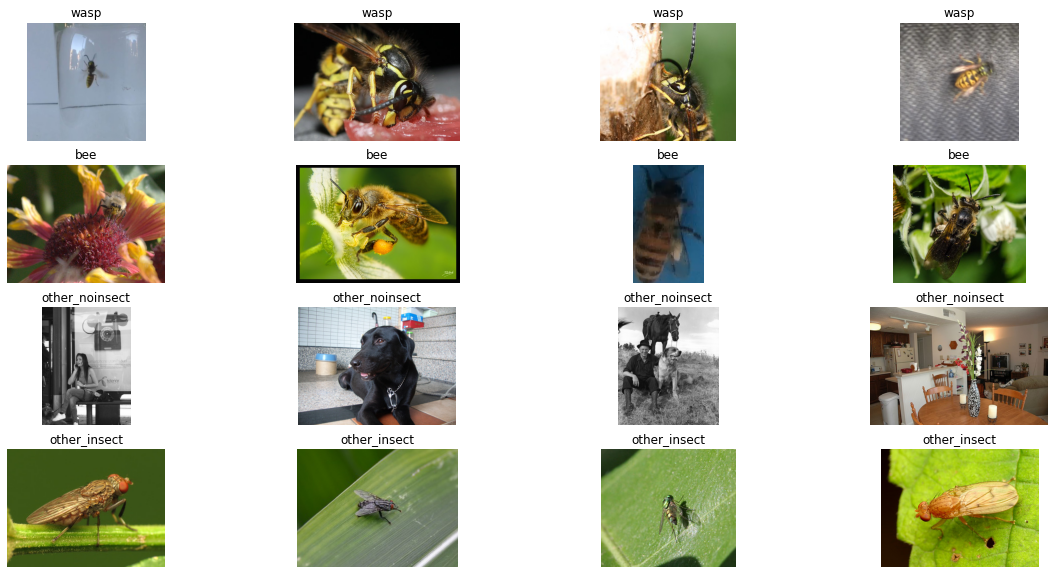

The training dataset contains 9136 images.
The validation dataset contains 2285 images.


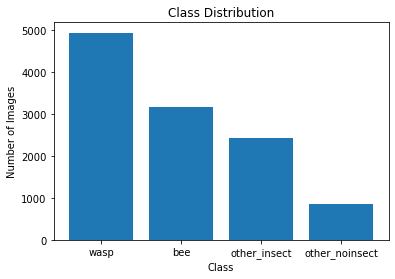

In [3]:
def prep_display_data(data_path):
    '''Check the contents of the data folder'''
    
    # Check the contents of the data folder
    data_folder = pathlib.Path(data_path)
    # Check if the data folder exists
    if data_folder.exists():
        # Create a list of the contents of the data folder
        data_folder_contents = list(data_folder.glob('*/*'))
        # Create a list of the classes in the data folder
        classes = [item.name for item in data_folder.glob('*') if item.is_dir()]
        # Print the classes in the data folder
        print(f'The data folder contains the following classes: {classes}')
        # Create a dictionary to store the class distribution
        class_distribution = {}
        # Create a list to store the paths of the images
        image_paths = []
        # Create a list to store the labels of the images
        labels = []
        # Loop through the classes in the data folder
        for class_name in classes:
            # Create a list of the contents of the class folder
            class_folder_contents = list(data_folder.glob(f'{class_name}/*'))
            # Filter out any directories that start with ".ipynb_checkpoints"
            class_folder_contents = [item for item in class_folder_contents if not item.name.startswith('.ipynb_checkpoints')]
            # Print the number of images in the class folder
            print(f'The class {class_name} contains {len(class_folder_contents)} images.')
            # Update the class distribution dictionary with the class name and the number of images
            class_distribution[class_name] = len(class_folder_contents)
            # Add the paths of the images to the image paths list
            image_paths.extend(class_folder_contents[:4])
            # Add the labels of the images to the labels list
            labels.extend([class_name]*4)
        # Create a figure to display the images
        fig, axes = plt.subplots(4, 4, figsize=(20, 10))
        # Loop through the image paths and labels
        for i, (image_path, label) in enumerate(zip(image_paths, labels)):
            # Load the image
            image = Image.open(image_path)
            # Display the image
            axes[i//4, i%4].imshow(image)
            axes[i//4, i%4].set_title(label)
            axes[i//4, i%4].axis('off')
        # Show the figure
        plt.show()

        # Create train and validation dataframes
        train_data = []
        for class_name in classes:
            class_folder_contents = list(data_folder.glob(f'{class_name}/*'))
            class_folder_contents = [item for item in class_folder_contents if not item.name.startswith('.ipynb_checkpoints')]
            for item in class_folder_contents:
                train_data.append((item, class_name))
        train_df = pd.DataFrame(train_data, columns=['image', 'class'])
        train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)
        print(f'The training dataset contains {len(train_df)} images.')
        print(f'The validation dataset contains {len(val_df)} images.')

        # Create a figure to display the class distribution ordered from highest to lowest
        fig, ax = plt.subplots() 
        # Sort the class distribution dictionary by the number of images
        class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1], reverse=True))
        # Plot the class distribution as a histogram
        ax.bar(class_distribution.keys(), class_distribution.values())
        # Set the title of the plot
        ax.set_title('Class Distribution')
        # Set the x-label of the plot
        ax.set_xlabel('Class')

        # Set the y-label of the plot
        ax.set_ylabel('Number of Images')
        # Show the plot
        plt.show()
    else:
        # Print an error message if the data folder does not exist
        print(f'The data folder {data_folder} does not exist.')

    return train_df, val_df

train_df, val_df = prep_display_data(data_path)


!!! Make Notes Here !!!

## 4. Build the model

In [4]:
# Set up our ViT model architecture

# Define the Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, emb_size):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Rearrange the input tensor x to have a new shape
        x = self.projection(x)
        x = rearrange(x, 'b e (h) (w) -> b (h w) e', h=x.shape[2], w=x.shape[3])
        return x
    
# Define the Multi-Head Self-Attention Layer

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0):
        super(MultiHeadAttention, self).__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.fc_out = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Split the input tensor x into num_heads pieces
        queries = rearrange(self.queries(x), 'b n (h d) -> b h n d', h=self.num_heads)
        keys = rearrange(self.keys(x), 'b n (h d) -> b h n d', h=self.num_heads)
        values = rearrange(self.values(x), 'b n (h d) -> b h n d', h=self.num_heads)
        
        # Perform a scaled dot-product attention
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) / (self.emb_size ** 0.5)
        attention = F.softmax(energy, dim=-1)
        attention = self.dropout(attention)
        
        # Apply the attention to the values
        out = torch.einsum('bhal, bhlv -> bhav', attention, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.fc_out(out)
        return out
    
# Define the Multi-Layer Perceptron (MLP) Layer

class MLP(nn.Module):
    def __init__(self, emb_size, mlp_hidden_dim, dropout=0.0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(emb_size, mlp_hidden_dim)
        self.fc2 = nn.Linear(mlp_hidden_dim, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
class Transformer(nn.Module):
    def __init__(self, emb_size, num_heads, mlp_hidden_dim, dropout=0.0):
        super(Transformer, self).__init__()
        self.attention = MultiHeadAttention(emb_size, num_heads, dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        self.mlp = MLP(emb_size, mlp_hidden_dim, dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attention(self.norm1(x)))
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x
    
# Define the Vision Transformer (ViT) Model

class ViT(nn.Module):
    def __init__(self, in_channels, patch_size, emb_size, img_size, num_classes, num_layers, num_heads, mlp_hidden_dim, dropout=0.0):
        super(ViT, self).__init__()
        num_patches = (img_size // patch_size) ** 2
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_size))
        self.transformer = nn.Sequential(*[
            Transformer(emb_size, num_heads, mlp_hidden_dim, dropout)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(emb_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embedding(x)
        b, n, _ = x.shape
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

## 5. Create the model


In [5]:
# Create a ViT model instance

# Define the model hyperparameters
in_channels = 3
patch_size = 16
emb_size = 768
img_size = 128
num_classes = 6
num_layers = 12
num_heads = 12
mlp_hidden_dim = 3072
dropout = 0.1


model = ViT(in_channels, patch_size, emb_size, img_size, num_classes, num_layers, num_heads, mlp_hidden_dim, dropout)


# 5.1 What is a Vision Transformer "seeing"?

!!! Make Notes Here !!!

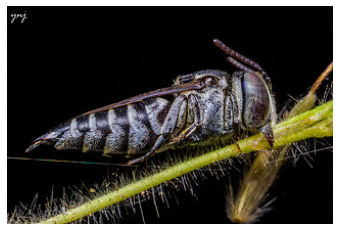

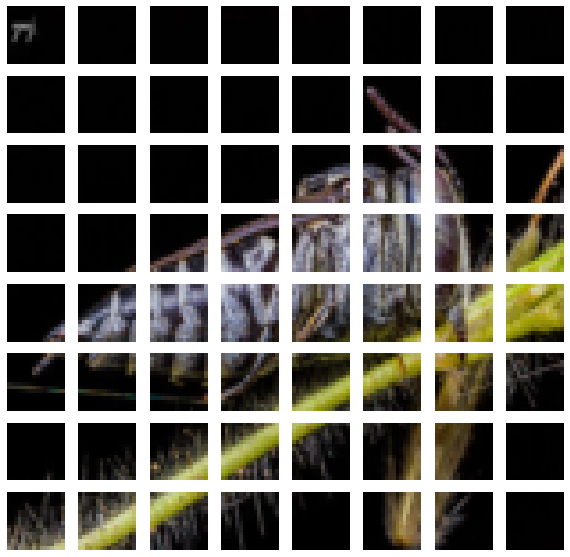

In [6]:
# Show a random image from the dataset
image_path = random.choice(train_df['image'])
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


# Show the image broken up into patches
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0)
patch_size = 16
patches = rearrange(image_tensor, 'b c (h s1) (w s2) -> b (h w) c s1 s2', s1=patch_size, s2=patch_size) # Rearrange the dimensions of the input tensor
n_patches = patches.shape[1] # Get the number of patches
n_patches_side = int(np.sqrt(n_patches))
fig, axes = plt.subplots(n_patches_side, n_patches_side, figsize=(10, 10))

for i in range(n_patches):
    patch = patches[0, i].permute(1, 2, 0)
    axes[i // n_patches_side, i % n_patches_side].imshow(patch)
    axes[i // n_patches_side, i % n_patches_side].axis('off')

# Show the image patches
plt.imshow(patch)
plt.axis('off')
plt.show()
patch = patches[0, i].unsqueeze(0).permute(0, 2, 3, 1).squeeze(0)
patches = patches[:, torch.randperm(patches.size(1))]

# Show the image patches plotted randomly in a single row
fig, ax = plt.subplots(1, n_patches, figsize=(20, 20))
for i in range(n_patches):
    patch = patches[0, i].permute(1, 2, 0)
    ax[i].imshow(patch)
    ax[i].axis('off')
plt.show()





!!! Make Notes Here !!!

## 6. Train the model

In [11]:
# Fit the model to the data

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the training function
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    total_batches = len(data_loader)
    train_progress_bar = tqdm(range(total_batches), desc="Training", leave=False)
    for batch_num, (images, labels) in enumerate(data_loader):
        train_progress_bar.set_description(f"Training Batch {batch_num+1}/{total_batches}")
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_progress_bar.update()
    train_progress_bar.close()
    return running_loss / len(data_loader), train_correct / train_total

# Define the validation function
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_progress_bar = tqdm(data_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in data_loader:
            val_progress_bar.set_description("Validating")
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_progress_bar.update()
    val_progress_bar.close()
    return running_loss / len(data_loader), val_correct / val_total

# Define the test function
'''Currently, the test function is not being used in the training loop. 
However, you can use it to evaluate the model on the test dataset after training.'''
def test(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_progress_bar = tqdm(data_loader, desc="Testing", leave=False)
    with torch.no_grad():
        for images, labels in data_loader:
            test_progress_bar.set_description("Testing")
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_progress_bar.update()
    test_progress_bar.close()
    return correct / total

# Move the model to the device
model.to(device)

# Define the batch size
batch_size = 32

# Load the dataset
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training dataframe
train_df = train_df.reset_index(drop=True)

# Create the training dataset
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

# Create the training data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load the validation dataframe
val_df = val_df.reset_index(drop=True)

# Create the validation dataset
val_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

# Create the validation data loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Define the number of epochs
num_epochs = 3

# Train the model
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/3


Epoch 1/3, Train Loss: 0.7566, Train Accuracy: 0.6949, Val Loss: 0.6791, Val Accuracy: 0.7328
Epoch 2/3


Epoch 2/3, Train Loss: 0.7115, Train Accuracy: 0.7200, Val Loss: 0.6567, Val Accuracy: 0.7360
Epoch 3/3


Epoch 3/3, Train Loss: 0.6609, Train Accuracy: 0.7426, Val Loss: 0.5582, Val Accuracy: 0.7814


## 6. Evaluate the results

!!! Make Notes Here !!!

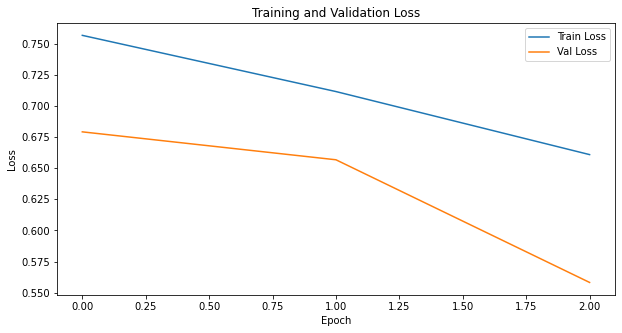

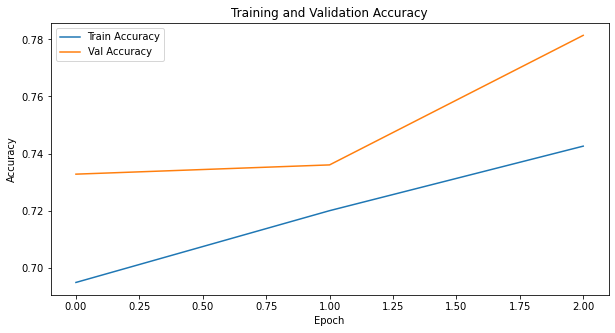

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>

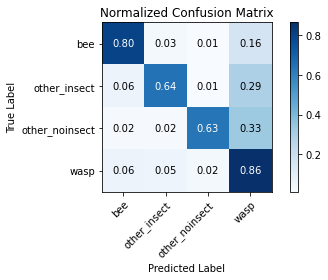

In [15]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, without Normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

# Get the predictions for the validation dataset
y_pred = []
y_true = []
val_progress_bar = tqdm(val_loader, desc="Predicting", leave=False)
with torch.no_grad():
    for images, labels in val_progress_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
val_progress_bar.close()

# Pull the class names from the dataset
classes = val_dataset.classes

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, classes, normalize=True)

!!! Add Notes Here !!!

## 7. Inference
How does the model fair on some test images? Lets try some new images!
1. Find your own image image.
2. Upload it to this folder.
3. Add or edit the code below to run on the new image rather than images in the test folder.


In [10]:
# Run the model on a few test images

## 8. Explore hyperparameters

Now that you have a good baseline, consider how you might deal with this model's issues.
- How would you address issues in the dataset?
- How would you optimize training?

How does this model compare to the CNNs you've used? Training time? Accuracy? What are some of the hyperparameters that are in ViT that aren't in CNNs?

!!! Insert Notes Here!!!

## Bonus Exercises

- !!! Insert Cool Ideas Here !!!